# Homework 4: Modeling Text Data

### Team Member 1:
* UNI: mf3090
* Name: Michael Figueroa

### Team Member 2:
* UNI: baa2146
* Name: Brett Averso


### Task
The task is to do text classification on a dataset of complaints about traffic conditions to the city of Boston. You can find the data here: https://data.boston.gov/dataset/vision-zero-entry
There are two goals:
First, try to predict the type of complaint (“REQUESTTYPE”) from the complaint text.
Second, try to come up with a better categorization of the data into semantic categories.

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [1]:
cd data

C:\Users\Michael\Documents\COMS 4995 Applied  ML\Homework 4\data


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer
from sklearn.metrics import adjusted_rand_score
import itertools

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier

In [5]:
complaints = pd.read_csv("Vision_Zero_Entry.csv")

In [6]:
# Keep only rows for which the comments section has a value
complaints = complaints[complaints['COMMENTS'].notnull()]

# Keep on rows for which the comments section does not say 'Test'
complaints = complaints[complaints['COMMENTS'] != 'Test']

In [7]:
complaints.REQUESTTYPE.value_counts() , complaints.REQUESTTYPE.value_counts().shape

(of something that is not listed here                                                                         1422
 bike facilities don't exist or need improvement                                                               782
 people speed                                                                                                  745
 people run red lights / stop signs                                                                            662
 people don't yield while turning                                                                              461
 people double park their vehicles                                                                             426
 it’s hard to see / low visibility                                                                             389
 sidewalks/ramps don't exist or need improvement                                                               301
 people don't yield while going straight                                        

In [8]:
# Cleaning the target variable and consolidating categories manually

complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace('.*;(.*)', '\\1', regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace('\"', '', regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace("there's not enough time to cross the street", "people are not given enough time to cross the street", regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace("the roadway surface needs improvement", "the roadway surface needs maintenance", regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace("it's too far / too many lanes to cross", "people have to cross too many lanes / too far", regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace("there are no sidewalks or they need maintenance", "sidewalks/ramps don't exist or need improvement", regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace("bike facilities don't exist or need improvement", "there are no bike facilities or they need maintenance", regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace('people have to wait too long for the Walk signal', 'the wait for the Walk signal is too long', regex = True)
complaints['REQUESTTYPE'] = complaints['REQUESTTYPE'].replace('it’s hard for people to see each other', 'it’s hard to see / low visibility', regex = True)

In [9]:
complaints['REQUESTTYPE'].value_counts() , complaints['REQUESTTYPE'].value_counts().shape

(of something that is not listed here                     1425
 there are no bike facilities or they need maintenance     910
 people speed                                              746
 people run red lights / stop signs                        662
 people don't yield while turning                          461
 people double park their vehicles                         426
 it’s hard to see / low visibility                         419
 sidewalks/ramps don't exist or need improvement           343
 people don't yield while going straight                   264
 the roadway surface needs maintenance                     256
 people cross away from the crosswalks                     254
 the wait for the Walk signal is too long                  230
 people are not given enough time to cross the street      131
 people have to cross too many lanes / too far             109
 Name: REQUESTTYPE, dtype: int64, (14,))

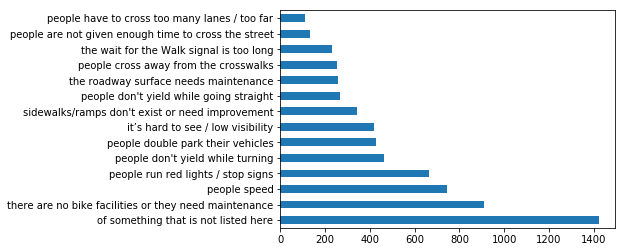

In [10]:
complaints['REQUESTTYPE'].value_counts().plot(kind='barh')

The bar chart indicates that there are plenty of complaints that are either a) misclassified as 'other' due to incompetence of the data entry clerk or b) there is a data imbalance consisting of many miscellaneous complaints. In the event of A, we can reclassify and predict the correct labels using the methods within this homework assignment. In the vent of B, we can use clustering and a new classification model to provide an improved classifcation framework for these complaints. 

In [11]:
complaints.REQUESTTYPE.value_counts()/complaints.shape[0] , complaints.shape

(of something that is not listed here                     0.214738
 there are no bike facilities or they need maintenance    0.137131
 people speed                                             0.112417
 people run red lights / stop signs                       0.099759
 people don't yield while turning                         0.069470
 people double park their vehicles                        0.064195
 it’s hard to see / low visibility                        0.063140
 sidewalks/ramps don't exist or need improvement          0.051688
 people don't yield while going straight                  0.039783
 the roadway surface needs maintenance                    0.038577
 people cross away from the crosswalks                    0.038276
 the wait for the Walk signal is too long                 0.034659
 people are not given enough time to cross the street     0.019741
 people have to cross too many lanes / too far            0.016426
 Name: REQUESTTYPE, dtype: float64, (6636, 11))

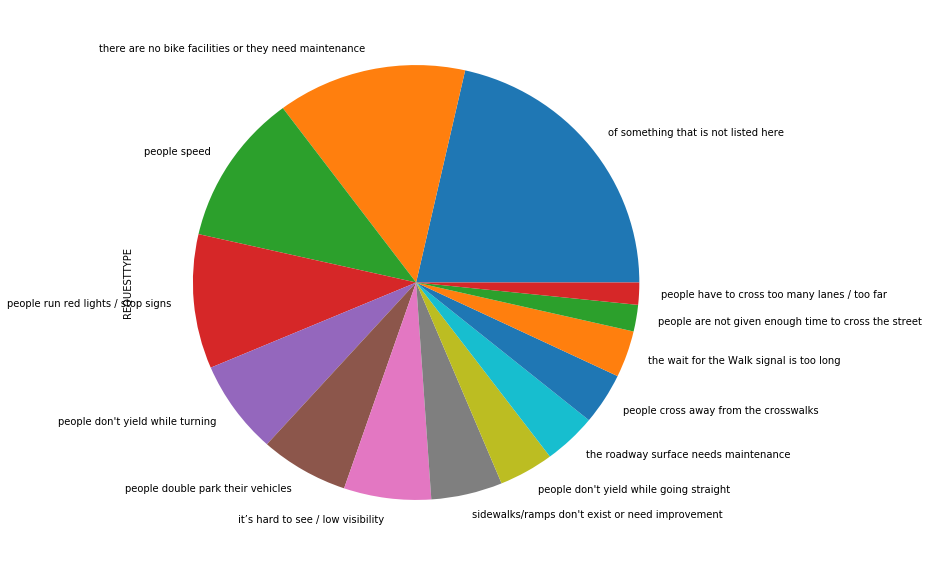

In [12]:
plt.figure(figsize=(10,10))
(complaints.REQUESTTYPE.value_counts()/complaints.shape[0]).plot(kind='pie')

The pie chart affirms our prior statement regarding 'other'. We note that the classes can be grouped into several larger, more macro categories: cyclist safety, pedestrian safety, dangerous driving, and poor road conditions. While these macro-categories are not particularly informative for Vision Zero, we believe these identifications give us context in text preprocessing and clustering. 

In [13]:
# Remove duplicate rows
complaints.drop_duplicates(subset= ['COMMENTS', 'REQUESTTYPE'], inplace=True)
complaints.shape

(6454, 11)

In [14]:
X = complaints.COMMENTS
y = complaints.REQUESTTYPE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

vect1 = CountVectorizer()
vect3 = CountVectorizer(min_df = 5)

In [15]:
vect1.fit_transform(X_train)
vect3.fit_transform(X_train)

<4840x1613 sparse matrix of type '<class 'numpy.int64'>'
	with 97414 stored elements in Compressed Sparse Row format>

In [16]:
print("Vocabulary size: {}".format(len(vect1.vocabulary_)))
print("First 20 features:\n{}\n".format(vect1.get_feature_names()[:200]))
print("Every 20th feature:\n{}".format(vect1.get_feature_names()[::20]))

Vocabulary size: 5738
First 20 features:
['00', '00am', '02124', '10', '100', '1000', '1000s', '101', '1010', '109', '10am', '10pm', '11', '115', '11a', '12', '128', '13', '1330', '13th', '14', '15', '16', '17', '18', '1a', '1st', '20', '200', '2000', '2009', '200k', '2014', '2015', '2016', '203', '20mph', '21', '22', '2201', '229', '24', '244', '25', '250', '257', '26', '27', '280', '2am', '2hr', '2nd', '30', '300', '30am', '30mph', '311', '318', '32', '342', '343', '345', '346', '35', '35mph', '365', '39', '390', '3a', '3ft', '3rd', '40', '40mph', '415', '426', '45', '45am', '473', '4pm', '4th', '50', '500', '501', '503', '50mph', '50s', '524', '544', '55', '555', '564', '57', '5am', '5min', '5mph', '5mpne8', '5pm', '5th', '60', '60mph', '65', '65mph', '6am', '6pm', '70', '74', '75', '7am', '7pm', '7th', '80', '802', '85', '88', '899', '8am', '8th', '90', '90º', '93', '93n', '93s', '98', '99', '9am', '_all', '_never_', 'a1', 'aact', 'aaron', 'abandon', 'abates', 'abide', 'ability', '

In [17]:
print("Vocabulary size: {}".format(len(vect3.vocabulary_)))
print("First 20 features:\n{}\n".format(vect3.get_feature_names()[:200]))
print("Every 20th feature:\n{}".format(vect3.get_feature_names()[::20]))

Vocabulary size: 1613
First 20 features:
['00', '10', '100', '12', '15', '16', '18', '1st', '20', '24', '25', '30', '35', '40', '40mph', '45', '4th', '50', '500', '80', '90', '93', 'ability', 'able', 'about', 'above', 'abruptly', 'absolutely', 'accelerate', 'access', 'accessible', 'accident', 'accidents', 'accommodate', 'across', 'activated', 'active', 'actually', 'ada', 'adams', 'add', 'added', 'addicts', 'adding', 'addition', 'additional', 'additionally', 'adjusted', 'adults', 'afraid', 'after', 'afternoon', 'afternoons', 'again', 'against', 'aggressive', 'aggressively', 'ago', 'ahead', 'albany', 'aligned', 'alignment', 'all', 'alley', 'allow', 'allowed', 'allowing', 'allows', 'allston', 'almost', 'alone', 'along', 'already', 'also', 'alternative', 'although', 'always', 'am', 'ambulances', 'american', 'amory', 'amount', 'an', 'and', 'andrew', 'angle', 'angry', 'another', 'any', 'anyone', 'anything', 'anyway', 'anywhere', 'apart', 'appear', 'approach', 'approaching', 'arboretum', 'arb

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [18]:
def pipeline_summary(cv_scores, mean_score, macro, micro):
    """Call This method to summarize results of our models which use only pipeline.
            
    """
    print("cv_scores: {}\n\nmean_cv_score: {:.3f}\ntest_macro: {:.3f}\ntest_micro: {:.3f}".format(cv_scores, mean_score, macro, micro))

In [19]:
def gridsearch_summary(best_score, macro, micro):
    """Call this method to summarize results of our modls which use gridsearch.
    """
    
    print("best_grid_score: {:.3f}\ntest_macro: {:.3f}\ntest_micro: {:.3f}".format(best_score, macro, micro))

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '%.3f'%(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
def baseline_model_1(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(), LogisticRegression())
    pipe.fit(X_train, y_train)
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring ='f1_macro', cv = 10)
    mean_score = np.mean(cv_scores)
    y_pred = pipe.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return cv_scores, mean_score, macro, micro, confusion

# mean_cv_score: 0.511
# test_macro: 0.538
# test_micro: 0.584

In [22]:
cv_scores1, mean_score1, macro1, micro1, confusion1 = baseline_model_1(X_train, X_test, y_train, y_test)
pipeline_summary(cv_scores1, mean_score1, macro1, micro1)

c:\users\michael\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\michael\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cv_scores: [ 0.51537885  0.5094241   0.52257044  0.50137019  0.5479334   0.54914361
  0.55012571  0.5141494   0.51468646  0.52436088]

mean_cv_score: 0.525
test_macro: 0.538
test_micro: 0.584


In [23]:
assert macro1 > 0.529

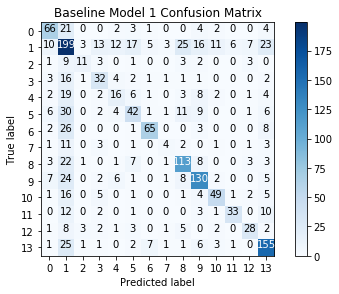

In [24]:
plt.figure()
plot_confusion_matrix(confusion1, classes=list(np.unique(y.values)), title ='Baseline Model 1 Confusion Matrix')
plt.show()

Looking at the confusion matrix, it's clear in column 1, 'of somethign not listed here' (we will refer to this as 'other'), that when the classifier missclassifies, it's because it's because the 'other' label is overweighted. This is expected because the data inherently posses this imbalance. Resultantly, most misclassified labels are marked to 'other'. Alternatively, when we examine row 1 'other, we can see the classifier has predicted different labels from the ground truth. The classifier particularly predicted labels 'too many people crossing the lane' and 'people don't yield...' although these 25 and 17 respective instances are truely labelled as 'other'. This is evidence that there are plenty of complaints which that y target has inaccurately captured the true nature of the event. These observations reaffirm our prior beliefs regarding the 'other' label, as described in the histogram earlier.

In [25]:
def baseline_model_2(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(min_df=3), LogisticRegression())
    pipe.fit(X_train, y_train)
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring ='f1_macro', cv = 10)
    mean_score = np.mean(cv_scores)
    y_pred = pipe.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return cv_scores, mean_score, macro, micro, confusion

# mean_cv_score: 0.520
# test_macro: 0.538
# test_micro: 0.582

In [26]:
# cv_scores2, mean_score2, macro2, micro2, confusion2 = baseline_model_2(X_train, X_test, y_train, y_test)
# pipeline_summary(cv_scores2, mean_score2, macro2, micro2)

In [27]:
def baseline_model_3(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(min_df=5), LogisticRegression())
    pipe.fit(X_train, y_train)
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring ='f1_macro', cv = 10)
    mean_score = np.mean(cv_scores)
    y_pred = pipe.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return cv_scores, mean_score, macro, micro, confusion

# mean_cv_score: 0.515
# test_macro: 0.539
# test_micro: 0.577

In [28]:
# cv_scores3, mean_score3, macro3, micro3, confusion3 = baseline_model_3(X_train, X_test, y_train, y_test)
# pipeline_summary(cv_scores3, mean_score3, macro3, micro3)

In [29]:
def baseline_model_4(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(min_df=5, stop_words="english"), LogisticRegression())
    pipe.fit(X_train, y_train)
    cv_scores = cross_val_score(pipe, X_train, y_train, scoring ='f1_macro', cv = 10)
    mean_score = np.mean(cv_scores)
    y_pred = pipe.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return cv_scores, mean_score, macro, micro, confusion

# mean_cv_score: 0.499
# test_macro: 0.525
# test_micro: 0.585

In [30]:
# cv_scores4, mean_score4, macro4, micro4, confusion4 = baseline_model_4(X_train, X_test, y_train, y_test)
# pipeline_summary(cv_scores4, mean_score4, macro4, micro4)

In [31]:
def baseline_model_5(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(), RandomForestClassifier(n_estimators=110, max_depth=20))
    param_grid = {'countvectorizer__min_df': [1, 5]}
    grid = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv = 10)
    grid.fit(X_train, y_train)
    best_score = grid.best_score_
    y_pred = grid.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return best_score, macro, micro, confusion, grid

# {'countvectorizer__min_df': 1, 'normalizer': None} macro: 0.538 -> LOGISTIC
# {'countvectorizer__min_df': 5, 'normalizer': True} macro: 0.483 -> LOGISTIC
# {'countvectorizer__min_df': 5, 'max_features': 20, 'n_estimators': 110} -> RANDOMFORESTCLASSIFIER

# best_grid_score: 0.424
# test_macro: 0.418
# test_micro: 0.530

In [32]:
# best_score5, macro5, micro5, confusion5, grid5 = baseline_model_5(X_train, X_test, y_train, y_test)
# gridsearch_summary(best_score5, macro5, micro5)

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [33]:
# Using grid search on the n_grams
def ngrams_model_6(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(), LogisticRegression())
    param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2),(1, 3)],
                 'countvectorizer__min_df': [1,3,5]}
    grid = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv = 3)
    grid.fit(X_train, y_train)
    best_score = grid.best_score_
    y_pred = grid.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return best_score, macro, micro, confusion, grid, y_pred

# TEST 1:
# param_grid: [(1, 1), (1, 2),(2, 3), (3, 3), (5, 5)]
# best_param: {'countvectorizer__ngram_range': (1, 2)}
# best_grid_score: 0.512
# test_macro: 0.540
# test_micro: 0.586

#Test 2:
# param_grid: [(1, 1), (1, 2),(1, 3)]
# best_param: {'countvectorizer__ngram_range': (1, 3)}
# best_grid_score: 0.514
# test_macro: 0.538
# test_micro: 0.586

# Test 3:
# param_grid: {'ngram_range': [(1, 1), (1, 2),(1, 3)], 'min_df': [1,3,5]}
# best_param: {'countvectorizer__min_df': 1, 'countvectorizer__ngram_range': (1, 2)}    
# best_grid_score: 0.535
# test_macro: 0.552
# test_micro: 0.601

In [34]:
best_score6, macro6, micro6, confusion6, grid6, y_pred6 = ngrams_model_6(X_train, X_test, y_train, y_test)
gridsearch_summary(best_score6, macro6, micro6)

best_grid_score: 0.535
test_macro: 0.552
test_micro: 0.601


#### ngrams_model6 was our strongest model. It employs logistic regression with minimum document frequency of 1, and incorporates 1-grams and bi-grams 

In [35]:
assert macro6 > .540

In [36]:
def char_ngrams_model_7(X_train, X_test, y_train, y_test):
    
    # We can also use analyzer ="char" This does not respect word boundaries
    pipe = make_pipeline(CountVectorizer(analyzer="char"), LogisticRegression())
    param_grid = {"countvectorizer__ngram_range": [(2, 2), (1, 2),(2, 3), (3, 4)]}
    grid = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv = 3)
    grid.fit(X_train, y_train)
    best_score = grid.best_score_
    y_pred = grid.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return best_score, macro, micro, confusion, grid

# Test 1:
# param_grid: {"ngram_range": [(2, 2), (1, 2),(2, 3), (3, 4)]}
# ###THIS MIGHT MEAN THAT CHAR WB MAY NOT BE WORKING SINCE ITS CHOOSING (3,4)
# best_param: {'countvectorizer__ngram_range': (3, 4)}
# best_grid_score: 0.498
# test_macro: 0.514
# test_micro: 0.559

# Test 2:
# param_grid: {"ngram_range": [(2, 2), (1, 2), (2, 3), (3, 4)]}
# best_param: {'countvectorizer__ngram_range': (3, 4)}
# best_grid_score: 0.515
# test_macro: 0.519 
# test_micro: 0.567
# ###Character CHAR level n-gram analyzer was a better analyzer for model_7. 

In [37]:
# best_score7, macro7, micro7, confusion7, grid7 = char_ngrams_model_7(X_train, X_test, y_train, y_test)
# gridsearch_summary(best_score7, macro7, micro7)

In [38]:
def ngrams_model_8(X_train, X_test, y_train, y_test):
    
    pipe = make_pipeline(CountVectorizer(ngram_range=(1,2)), MLPClassifier(hidden_layer_sizes=(100,), activation = 'logistic', max_iter=50,verbose=True))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return macro, micro, confusion, pipe

In [39]:
# macro, micro, confusion, pipe = ngrams_model_8(X_train, X_test, y_train, y_test)

# Task4 - Visualize Results [10 points]

In [40]:
# class_results=pd.read_csv(StringIO(classification_report(y_test, y_pred6, digits=2)), sep=(" 0"), header = None, names = ['precision','recall','f1-score & support'])
# class_results = class_results[1:]
# class_results

Precision is a measure of how useful our model is at classifying complaints into the appropraite labels. For example, for the label "it's hard to see / low visibility", the precision is .64. Therefore 64% of complaints classified to this are true positivees while 36% are false positives.

Recall is a measure of the completeness for each respective label. Therefore our model only correctly captured 59% of the class "it's hard to see / low visibility", and 41% of complaints belonging to this class did not accurately classify under the model.

With that said, looking at the overall table and reviewing our f1 score (best measure of accuracy, combines precision and recall), our best model is pretty weak with an average of .60 F1. There are some notable observations that can be taken from this table that may allow us to improve upon the model. 

For instance, there is a substantial gap between precision and recall on "people are not given enough time to cross the street" and "people have to cross too many lanes". In the former class, precision is above average and yet the recall is below. This suggests that of the classifications the model makes for this class, the misclassification are on par average with other labels, however the model is missing many complaints that belong to this class. Some ways to examine this further could be to examine the token counts for complaints in this class, or to preprocess these complaints so as to improve the tokenization. In the latter class regarding people crossing the lanes, it appears both precision and recall are well below the average, and therefore the classifier is all around terrible at capturing these complaints. If we improve the classifier in any way, both of these scores should likely rise up in tandem.

In [41]:
#plt.figure()
#plot_confusion_matrix(confusion2, classes=list(np.unique(y.values)), title='Confusion matrix 2')
#plt.show()

In [42]:
#plt.figure()
#plot_confusion_matrix(confusion3, classes=list(np.unique(y.values)), title='Confusion matrix 3')
#plt.show()

In [43]:
# plt.figure()
# plot_confusion_matrix(confusion4, classes=list(np.unique(y.values)), title='Confusion matrix 4')
# plt.show()

In [44]:
# plt.figure()
# plot_confusion_matrix(confusion5, classes=list(np.unique(y.values)), title='Confusion matrix 5')
# plt.show()

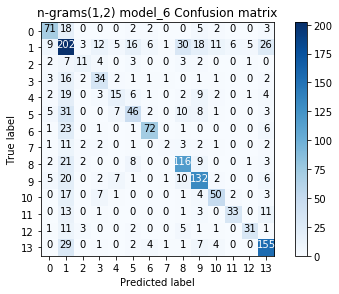

In [45]:
plt.figure()
plot_confusion_matrix(confusion6, classes=list(np.unique(y.values)), title='n-grams(1,2) model_6 Confusion matrix')
plt.show()

This is the confusion matrix for our best ngram classifer. As confirmed before, we can see the impact of the imbalance for complaints belonging to the 'other' class. However our confusion matrix has marginally improved from the prior.

In [46]:
# plt.figure()
# plot_confusion_matrix(confusion7, classes=list(np.unique(y.values)), title='Confusion matrix 7')
# plt.show()

In [47]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

In [48]:
# lr = grid6.best_estimator_.named_steps['logisticregression']

# feature_names = np.array(grid6.best_estimator_.named_steps['countvectorizer'].get_feature_names())
# n_classes = len(lr.classes_)
# fig, axes = plt.subplots(n_classes, figsize=(20, 80))
# for ax, coef, label in zip(axes.ravel(), lr.coef_, lr.classes_):
#     ax.set_title(label)
#     plot_important_features(coef, feature_names, top_n=20, ax=ax)

# plt.tight_layout()

#note this is commented for Travis to run faster.

Upon review of the most predictive feature names for every class, the words which are identified make a lot of intuitive sense. Therefore it passes our sense check. Going deeper and comparing high f1-scoring classes to lower, we can make a couple conclusions as well.

It's evident that for high scoring classes, the complaints typically contain one or two critical tokenized words that are almost unavoidable in the associated complaint. For instance, the "...no bike facilities.." class always contains the words bike, bikes, bicycles, in its complaints which is why the label is easy for our classifier. These word variants are not shared by the other labels and so it's an easy classification from both an precision and recall standpoint.

However, for lower scoring labels such as "people have to cross too many lanes", there is a strong correlation between the word 'wide' and the label, but that's about it. And this makes intuitive sense because the recall score is average, but the recall score is low. So 'wide' is most certainly a good predictor for this label, but the classifier is failing to capture other latent words in the corpus that are good indicators of this label. You can see this not only from the fairly homogenous word feature importances graph above, but also as discussed in the recall table prior.

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [49]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,n_words=20):
    """This method will be called to print topics from our NMF 
    """
    sorting = np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [50]:
def plot_important_features_2(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

In [51]:
def clustering_kmeans(k,X, y):
    new_X = CountVectorizer(min_df=5).fit_transform(X)
    kmeans = KMeans(k)
    kmeans.fit_transform(new_X)
    y_pred = kmeans.predict(new_X)
    
    comparison = np.concatenate([X.values.reshape(len(X),1), y.reshape(len(y),1), y_pred.reshape(len(y_pred),1)], axis = 1)
    comparison = pd.DataFrame(comparison)
    comparison.columns =['COMMENTS','REQUESTTYPE', 'CLUSTER']
    
    return y_pred, comparison

In [52]:
y_pred, comparison = clustering_kmeans(5, X, y)

c:\users\michael\anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [53]:
comparison

,COMMENTS,REQUESTTYPE,CLUSTER
0,Broadway Bridge is wide & off highway ramps. V...,there are no bike facilities or they need main...,4
1,This intersection is dangerous. Cars don't fol...,of something that is not listed here,4
2,It's terrifying to walk over here. It seems li...,people don't yield while going straight,4
3,cars coming around the corner of this wide one...,it’s hard to see / low visibility,1
4,"as you come off the bike path, it's unclear ho...",people don't yield while turning,4
5,This intersection is very confusing.,of something that is not listed here,0
6,people walking go against the light because we...,the wait for the Walk signal is too long,0
7,Getting from the T stop to the pedestrian brid...,the wait for the Walk signal is too long,1
8,I will be coming down to the intersection alon...,people don't yield while turning,4
9,"This is a crosswalk by a school, and there is ...",sidewalks/ramps don't exist or need improvement,2


This is a mapping of our documents to cluster classifications from the k-means algorithm (5 centroids employed). We observed from this table that the mapping was unreliable and later you will see an ARI score that reflects this.

In [70]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [71]:
def nmf(X, n_samples, n_features, n_topics, n_top_words):
    data_samples = X
    tfidf_vectorizer = TfidfVectorizer(min_df=5, max_features=n_features, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    tf_vectorizer = CountVectorizer(min_df=5,max_features=n_features, stop_words='english')
    nmf = NMF(n_components=n_topics, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)
    
    return tf_vectorizer

In [72]:
tf_vectorizer = nmf(X, n_samples = 8535, n_features = 1613, n_topics = 3, n_top_words = 20)

Topic #0:
pedestrians stop light walk cars crosswalk drivers cross red sign yield intersection don turn right signal turning run st crossing
Topic #1:
bike lane lanes left right turn cars need traffic straight park double road facilities bikes parked parking dangerous needs ave
Topic #2:
street people way speed park drive road fast cars parking traffic wrong dangerous sidewalk narrow double cut area st sidewalks



These topics have words which have cohesive meaning and an intuitive label can be made. Topic 0 is in regards to unsafe intersections, topic 1 is for unsafe cycling conditions, and topic 2 is in regards to unsafe road conditions. We tried running the NMF with a higher quantity of desired topics but found that the intuitive meanings to the topics became diluted and unclear. Therefore we thought these less granular labels may be of use.

In [73]:
# For every unique value in REQUESTTYPE we relablled and encoded our classes from zero to 13.

y_labeled = y.replace('it’s hard to see / low visibility',0)
y_labeled.replace('of something that is not listed here',1, inplace=True)
y_labeled.replace('people are not given enough time to cross the street',2, inplace=True)
y_labeled.replace('people cross away from the crosswalks',3, inplace=True)
y_labeled.replace("people don't yield while going straight",4, inplace=True)
y_labeled.replace("people don't yield while turning",5, inplace=True)
y_labeled.replace('people double park their vehicles',6, inplace=True)
y_labeled.replace('people have to cross too many lanes / too far',7, inplace=True)
y_labeled.replace('people run red lights / stop signs',8, inplace=True)
y_labeled.replace('people speed',9, inplace=True)
y_labeled.replace("sidewalks/ramps don't exist or need improvement",10, inplace=True)
y_labeled.replace('the roadway surface needs maintenance',11, inplace=True)
y_labeled.replace('the wait for the Walk signal is too long',12, inplace=True)
y_labeled.replace('there are no bike facilities or they need maintenance',13, inplace=True)

In [1]:
y_labeled

NameError: name 'y_labeled' is not defined

In [74]:
# with our enumerated labels, we now replace them with our NMF topic labels.

nmf_labeled = y_labeled.replace(1,14)
nmf_labeled.replace(3, 2, inplace = True)
nmf_labeled.replace(4, 0, inplace = True)
nmf_labeled.replace(5, 0, inplace = True)
nmf_labeled.replace(6, 1, inplace = True)
nmf_labeled.replace(7, 0, inplace = True)
nmf_labeled.replace(8, 0, inplace = True)
nmf_labeled.replace(9, 2, inplace = True)
nmf_labeled.replace(10, 0, inplace = True)
nmf_labeled.replace(11, 2, inplace = True)
nmf_labeled.replace(12, 2, inplace = True)
nmf_labeled.replace(13, 0, inplace = True)

# Topic 0 = unsafe intersections
# Topic 1 = unsafe cyclist conditions
# Topic 2 = unsafe road conditions`

# 'there are no bike facilities or they need maintenance' = unsafe cyclist conditions 0, 0
# 'of something that is not listed here' = other # replace randomly with one of the classes
# "sidewalks/ramps don't exist or need improvement" = unsafe road conditions 2, 2
# 'it’s hard to see / low visibility' = unsafe road conditions 3, 2
# 'people are not given enough time to cross the street' = unsafe intersections 4, 0
# "people don't yield while going straight" = unsafe intersections 5, 0
# 'people double park their vehicles' = unsafe cyclist conditions 6, 1
# 'people cross away from the crosswalks' = unsafe intersections 7, 0
# 'people run red lights / stop signs' = unsafe intersections 8, 0
# 'people speed' =  unsafe road conditions 9, 2
# 'the wait for the Walk signal is too long' = unsafe intersections 10, 0
# 'people have to cross too many lanes / too far' = unsafe road conditions 11, 2
# 'the roadway surface needs maintenance' = unsafe road conditions 12, 2
# "people don't yield while turning" = unsafe intersections 13, 0

In [75]:
def LatentDirichlet(X, n_topics, n_features, n_top_words):
    tf = tf_vectorizer.fit_transform(X)
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=1)
    lda.fit(tf)
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)

In [76]:
LatentDirichlet(X, n_topics = 8, n_features = 1613, n_top_words = 20)

Topic #0:
stop pedestrians light cross cars people crosswalk drivers walk red sign intersection crossing yield don run lights street traffic right
Topic #1:
school speed traffic trucks rush kids morning hour cycle bicyclists lots st block buses need limit blocking hours bike zone
Topic #2:
parking park double street people lot children cars parked near police corner traffic neighborhood constantly safety area lines live frequently
Topic #3:
ave road bridge sidewalk comm mass traffic bike construction safe ramp biking potholes dorchester surface moving unsafe large bikes backs
Topic #4:
street way cars people drive road speed sidewalk fast traffic sidewalks dangerous speeding area narrow parked needs wrong coming walk
Topic #5:
lane bike right lanes left turn cars needs cyclists straight intersection need traffic drivers bikers dangerous turning people better car
Topic #6:
people bike use lanes day road street speed dangerous cut park avoid bikes center like space curb cars vehicles bic

In [77]:
list(np.unique(y))

['it’s hard to see / low visibility',
 'of something that is not listed here',
 'people are not given enough time to cross the street',
 'people cross away from the crosswalks',
 "people don't yield while going straight",
 "people don't yield while turning",
 'people double park their vehicles',
 'people have to cross too many lanes / too far',
 'people run red lights / stop signs',
 'people speed',
 "sidewalks/ramps don't exist or need improvement",
 'the roadway surface needs maintenance',
 'the wait for the Walk signal is too long',
 'there are no bike facilities or they need maintenance']

In [78]:
lda_labeled = y_labeled.replace(1, 14)
lda_labeled.replace(0, 3, inplace = True)
lda_labeled.replace(2, 7, inplace = True)
lda_labeled.replace(3, 7, inplace = True)
lda_labeled.replace(4, 2, inplace = True)
lda_labeled.replace(5, 4, inplace = True)
lda_labeled.replace(6, 0, inplace = True)
lda_labeled.replace(7, 1, inplace = True)
lda_labeled.replace(8, 1, inplace = True)
lda_labeled.replace(9, 5, inplace = True)
lda_labeled.replace(10, 0, inplace = True)
lda_labeled.replace(11, 3, inplace = True)
lda_labeled.replace(12, 7, inplace = True)
lda_labeled.replace(13, 6, inplace = True)

# Topic #0: accessibility 
# Topic #1: unsafe intersections 
# Topic #2: school zone danger 
# Topic #3: poor road conditions 
# Topic #4: dangerous turns
# Topic #5: dangerous driving
# Topic #6: cyclist safety
# Topic #7: poor signals/signage

#  [it’s hard to see / low visibility', = Topic 1, 3
#  'of something that is not listed here', = other
#  'people are not given enough time to cross the street', = Topic 3, 7
#  'people cross away from the crosswalks', = Topic 4, 7
#  "people don't yield while going straight", = Topic 5, 2
#  "people don't yield while turning", = Topic 6, 4
#  'people double park their vehicles', = Topic 7, 0
#  'people have to cross too many lanes / too far', = Topic 8, 1
#  'people run red lights / stop signs', = Topic 9, 1
#  'people speed', = Topic 10, 5
#  "sidewalks/ramps don't exist or need improvement", = Topic Topic 11, 0
#  'the roadway surface needs maintenance', = Topic 12, 3
#  'the wait for the Walk signal is too long', = Topic 13, 7
#  'there are no bike facilities or they need maintenance'] = Topic 14, 6

In [79]:
print("K-Means ARI Score: {}".format(adjusted_rand_score(y_labeled, y_pred)))

print("NMF ARI Score: {}".format(adjusted_rand_score(y_labeled, nmf_labeled)))

print("LDA ARI Score: {}".format(adjusted_rand_score(y_labeled, lda_labeled)))

K-Means ARI Score: 0.004145856222873624
NMF ARI Score: 0.3922300304541313
LDA ARI Score: 0.7916194759821976


While NMF provided a decent macro-level clustering of the data, it's not likely that three clusters is very informative for users. The ARI score, which is a measure of how similar our labels are to the clusters, registered with a strong score for both LDA and NMF. Using LDA we were able to extrapolate a new set of class labels which provide a new perspective on the complaints that may be of use to the users of this dataset. We believe the LDA clusters have more usability and futhermore the ARI score suggests there is a good relationship between our clusters and the original labels.

In [80]:
assert adjusted_rand_score(y_labeled, lda_labeled) > .74
assert adjusted_rand_score(y_labeled, nmf_labeled) > .37
assert adjusted_rand_score(y_labeled, y_pred) > .002

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [81]:
# Add your code for task 6 here. You may use multiple cells. 

X_other = pd.DataFrame(np.concatenate([X.reshape(len(X),1), y.reshape(len(y),1), ], axis = 1))
X_other.columns = ['X', 'y']
X_other = X_other[X_other['y'] == 'of something that is not listed here']
X_other = X_other.X

In [82]:
def lda2(X, n_topics, n_features, n_top_words):
    tf_vectorizer = CountVectorizer(min_df=5,max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(X)
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
    lda.fit(tf)

    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)

In [83]:
lda2(X_other, n_topics = 3, n_features = 1613, n_top_words = 20)

Topic #0:
people way cars traffic street intersection cross walk crosswalk road stop park dangerous lane sidewalk light lights sign pedestrians bike
Topic #1:
turn left lane cars right street st traffic light ave drivers lanes intersection pedestrians way straight turning green people bike
Topic #2:
parking stop bus drivers lot area buses street st school signs pedestrians park traffic trucks streets used sidewalks safety station



We ran an LDA on the 'that is not listed here' label ('other'). From this LDA we found the most intuitive and semantically meaningful topics with three clusters. The new topics are as folows --

Topic 0: pertains to unsafe intersections, a label which has appeared in both our original NMF and LDA models. 
Topic 1: pertains to poor signals/signage, this label is also seen in the original LDA model.
Topic 2: pertains to school zone danger.

We believe the reason why these latent topics were not appropraitely classified in the original y target is due to poor data entry on part of the Boston DOT.

In [84]:
def global_lda_model(X, nmf_labeled):
    
    X_train, X_test, y_train, y_test = train_test_split(X, nmf_labeled, stratify = nmf_labeled, random_state = 0)
    
    pipe = make_pipeline(CountVectorizer(), LogisticRegression())
    param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2),(1, 3)],
                 'countvectorizer__min_df': [1,3,5]}
    grid = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv = 3)
    grid.fit(X_train, y_train)
    best_score = grid.best_score_
    y_pred = grid.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return best_score, macro, micro, confusion, grid 

# best_grid_score: 0.568
# test_macro: 0.588
# test_micro: 0.614

In [85]:
# best_score_lda, macro_lda, micro_lda, confusion_lda, grid_lda = global_lda_model(X, lda_labeled)
# gridsearch_summary(best_score_lda, macro_lda, micro_lda)

In [ ]:
def global_nmf_model(X, nmf_labeled):
    
    X_train, X_test, y_train, y_test = train_test_split(X, nmf_labeled, stratify = nmf_labeled, random_state = 0)
    
    pipe = make_pipeline(CountVectorizer(), LogisticRegression())
    param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2),(1, 3)],
                 'countvectorizer__min_df': [1,3,5]}
    grid = GridSearchCV(pipe, param_grid, scoring = 'f1_macro', cv = 3)
    grid.fit(X_train, y_train)
    best_score = grid.best_score_
    y_pred = grid.predict(X_test)
    macro = f1_score(y_test, y_pred, average="macro")
    micro = f1_score(y_test, y_pred, average="micro")
    confusion = confusion_matrix(y_test, y_pred)
    
    return best_score, macro, micro, confusion, grid 

# best_grid_score: 0.646
# test_macro: 0.633
# test_micro: 0.657

In [ ]:
best_score_nmf, macro_nmf, micro_nmf, confusion_nmf, grid_nmf = global_nmf_model(X, nmf_labeled)
gridsearch_summary(best_score_nmf, macro_nmf, micro_nmf)

The global NMF model, which incorporates our updates, ultimately provided the best unsupervised topic predictions. An interesting point to be made that we used NMF on the entire dataset but LDA to relabel the 'other' category. This method proved to provide the strongest F1-Macro score.

In [ ]:
assert macro_nmf > .63